In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import plotly.express as px
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from geopy.geocoders import Nominatim
import folium

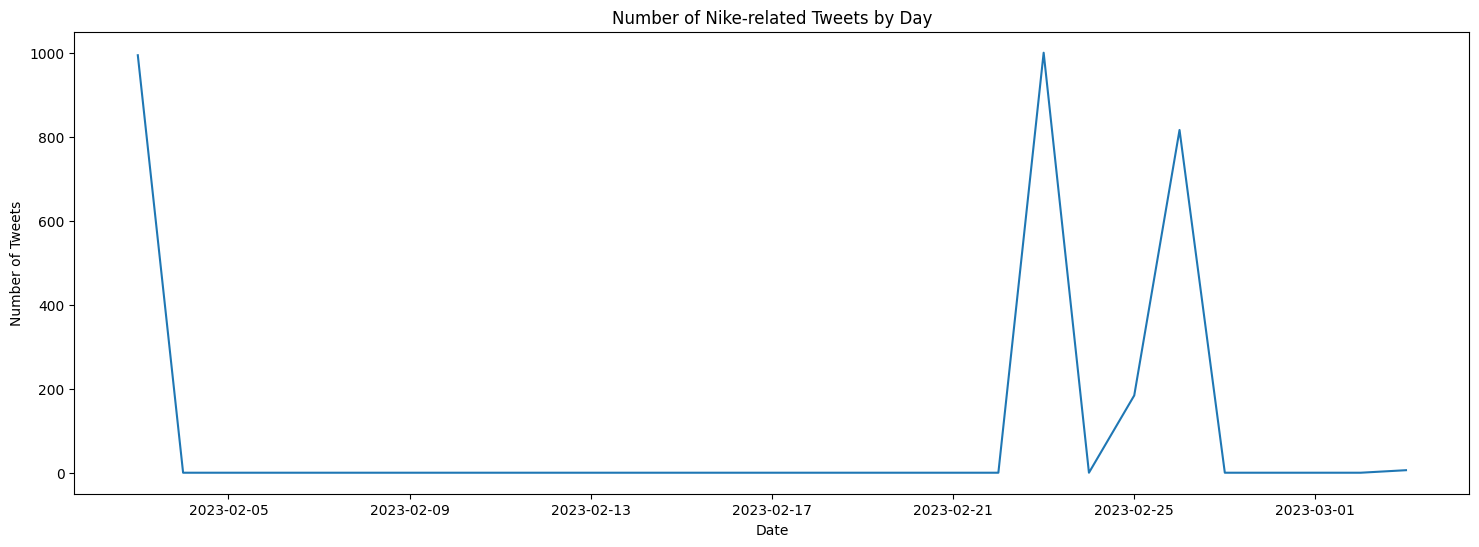

In [ ]:
# Load the dataset
df = pd.read_csv('nike_3k.csv')

# Convert the 'created_at' column to a datetime object
df['created_at'] = pd.to_datetime(df['created_at'])

# Set the 'created_at' column as the index
df.set_index('created_at', inplace=True)

# Resample the data by day and count the number of tweets
tweets_by_day = df.resample('D').count()['tweet_id']

# Plot the data
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(tweets_by_day)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.set_title('Number of Nike-related Tweets by Day')
plt.show()

Number of tweets mentioning Nike: 3000
Top 10 locations with the highest number of tweets mentioning Nike:
636 11th Avenue, New York, NY     465
636 11th Avenue, New York, NY     113
 Philadelphia, PA 19142, USA       90
555 Madison Ave, New York, NY      89
United States                      87
London, England                    49
Space, CA                          32
New Jersey, USA                    24
California, USA                    23
Florida, USA                       19
Name: location, dtype: int64


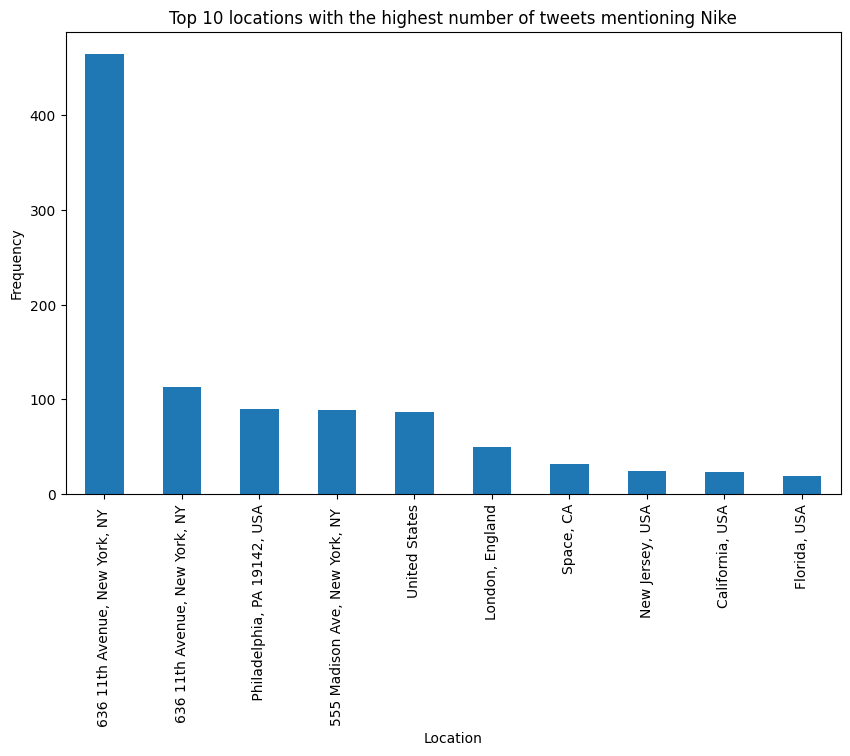

In [ ]:

# Get the number of tweets that mention Nike
num_tweets = df[df['text'].str.contains('Nike', case=False)].shape[0]
print("Number of tweets mentioning Nike:", num_tweets)

# Get the frequency of mentions from different geographical locations
geo_counts = df['location'].value_counts()
top_geo_counts = geo_counts.head(10)
print("Top 10 locations with the highest number of tweets mentioning Nike:")
print(top_geo_counts)

# Visualize the top 10 locations on a bar chart
top_geo_counts.plot(kind='bar', figsize=(10,6))
plt.title('Top 10 locations with the highest number of tweets mentioning Nike')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.show()

Average number of retweets per tweet: 0.3546666666666667
Average number of favorites per tweet: 1.932


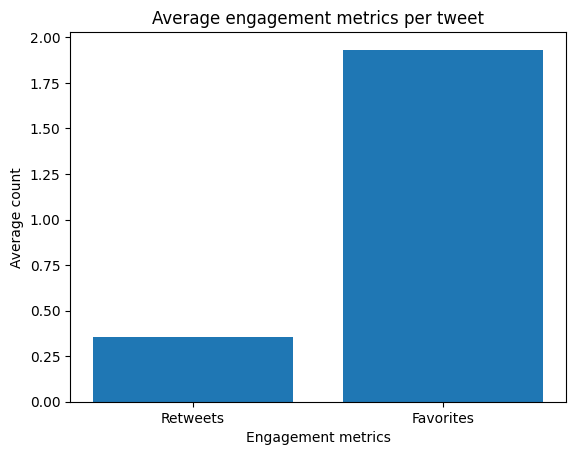

In [ ]:
# Calculate the average number of retweets, favorites
avg_retweets = df['retweet_count'].mean()
avg_favorites = df['favorite_count'].mean()
#avg_replies = df[df['text'].str.contains('@', case=False)]['tweet_id'].count()

print("Average number of retweets per tweet:", avg_retweets)
print("Average number of favorites per tweet:", avg_favorites)
#print("Average number of replies per tweet:", avg_replies)

# Visualize the engagement metrics on a bar chart
engagement_data = {'Retweets': avg_retweets, 'Favorites': avg_favorites}
plt.bar(engagement_data.keys(), engagement_data.values())
plt.title('Average engagement metrics per tweet')
plt.xlabel('Engagement metrics')
plt.ylabel('Average count')
plt.show()

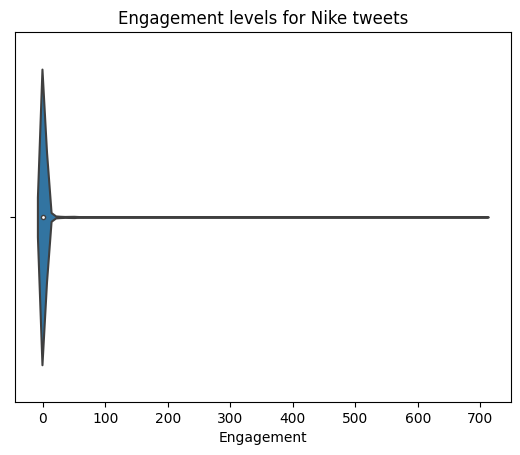

In [ ]:
# Calculate the engagement metrics for Nike's tweets
df['engagement'] = df['retweet_count'] + df['favorite_count']

# Plot a violin plot of the engagement levels for Nike's tweets
sns.violinplot(x=df['engagement'])
plt.title('Engagement levels for Nike tweets')
plt.xlabel('Engagement')
plt.show()


In [ ]:
print(df.columns)

Index(['author_id', 'statuses_count', 'location', 'verified',
       'followers_count', 'friends_count', 'listed_count', 'favourites_count',
       'tweet_id', 'text', 'lang', 'retweet_count', 'hashtags',
       'favorite_count'],
      dtype='object')


Average level of engagement per tweet: 2.29
month
2023-02    2.290247
2023-03    0.500000
dtype: float64


<ipython-input-16-e5660689abff>:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  engagement_by_month = df.groupby('month')['retweet_count', 'favorite_count'].sum().sum(axis=1) / tweet_counts


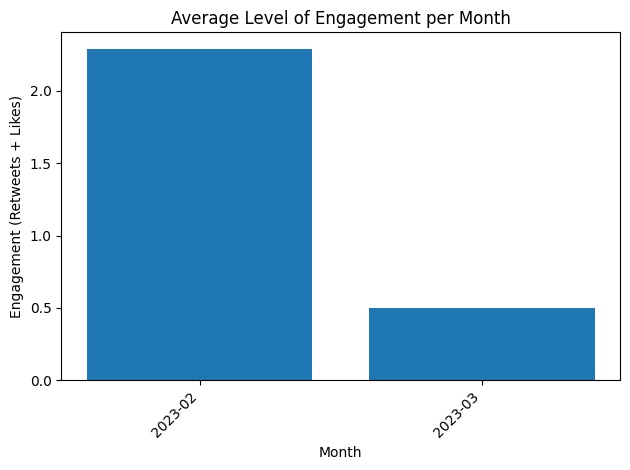

In [ ]:
# Load the dataset
df = pd.read_csv('nike_3k.csv')
# Calculate the level of engagement for each tweet
engagement = df[['retweet_count', 'favorite_count']].sum(axis=1)

# Print the average level of engagement
print(f"Average level of engagement per tweet: {engagement.mean():.2f}")

# Calculate the total number of tweets per month
df['created_at'] = pd.to_datetime(df['created_at'])
df['month'] = df['created_at'].dt.strftime('%Y-%m')
tweet_counts = df.groupby('month').size()

# Calculate the average level of engagement per month
engagement_by_month = df.groupby('month')['retweet_count', 'favorite_count'].sum().sum(axis=1) / tweet_counts

print(engagement_by_month)
# Visualize the level of engagement using a bar chart
plt.bar(engagement_by_month.index, engagement_by_month.values)
plt.title('Average Level of Engagement per Month')
plt.xlabel('Month')
plt.ylabel('Engagement (Retweets + Likes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Percentage of tweets with low engagement: 95.33%
Percentage of tweets with medium engagement: 2.73%
Percentage of tweets with high engagement: 1.93%


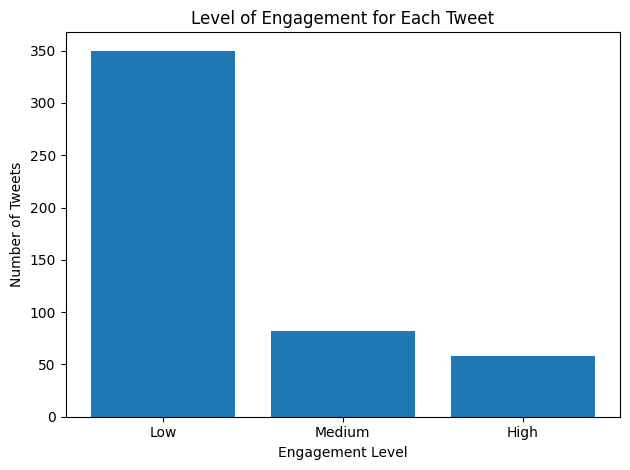

In [ ]:
# Calculate the total number of tweets in the dataset
total_tweets = len(df)

# Calculate the percentage of tweets with low, medium, and high engagement
low_engagement = len(engagement[engagement <= 5]) / total_tweets * 100
medium_engagement = len(engagement[(engagement > 5) & (engagement <= 20)]) / total_tweets * 100
high_engagement = len(engagement[engagement > 20]) / total_tweets * 100

# Print the percentage of tweets with low, medium, and high engagement
print(f"Percentage of tweets with low engagement: {low_engagement:.2f}%")
print(f"Percentage of tweets with medium engagement: {medium_engagement:.2f}%")
print(f"Percentage of tweets with high engagement: {high_engagement:.2f}%")

# Visualize the level of engagement using a bar chart
bins = [0, 5, 20, float('inf')]
bin_labels = ['Low', 'Medium', 'High']
engagement_bins = pd.cut(engagement, bins=bins, labels=bin_labels)
engagement_counts = engagement_bins.value_counts()
plt.bar(engagement_counts.index, engagement_counts.values)
plt.title('Level of Engagement for Each Tweet')
plt.xlabel('Engagement Level')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()

In [ ]:


# Define a function to clean the text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Clean the text data in the "text" column
df['clean_text'] = df['text'].apply(clean_text)

# Combine all the cleaned text into a single string
all_text = ' '.join(df['clean_text'])

# Split the text into individual words
words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Print the 10 most common words and their counts
for word, count in word_counts.most_common(10):
    print(word + ': ' + str(count))

# Create an interactive bar chart of the most common words using Plotly
word_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
word_df = word_df.sort_values('count', ascending=False)[:10]
fig = px.bar(word_df, x=word_df.index, y='count', labels={'x': 'Word', 'y': 'Frequency'})
fig.update_layout(title='Most common words in tweets mentioning Nike', showlegend=False)
fig.show()

nike: 3341
the: 1628
to: 1393
on: 1373
out: 1340
i: 1322
fashion: 1318
check: 1297
style: 1292
shoes: 1284


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('corpus')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Error loading corpus: Package 'corpus' not found in index


False

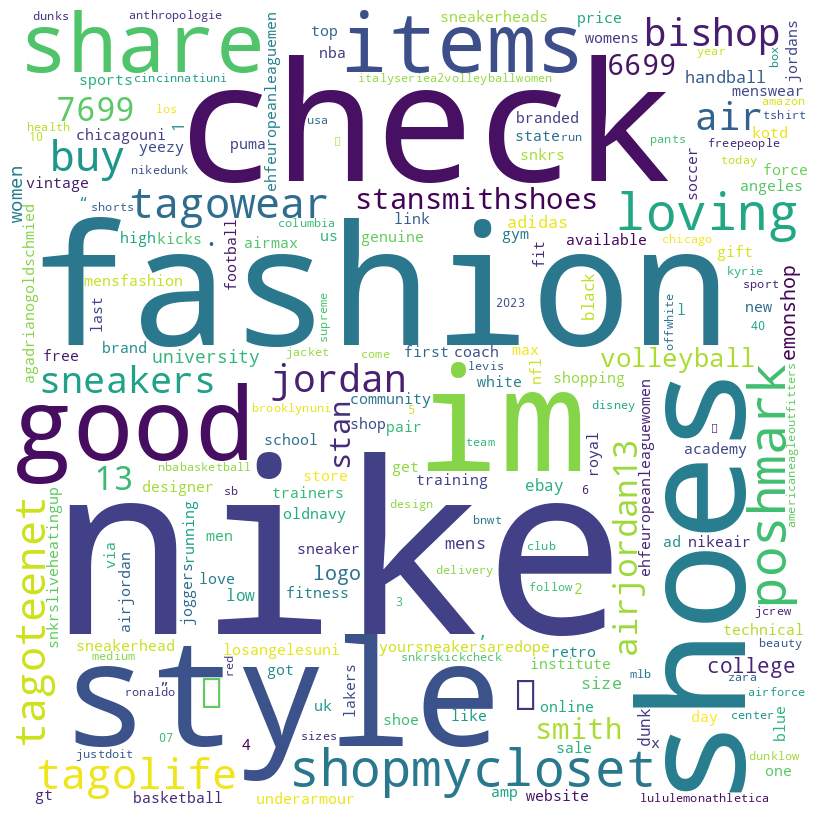

In [ ]:
# Load the dataset
nike_df = pd.read_csv('nike_3k.csv')

# Define function to remove URLs, mentions, and punctuations from text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.lower()

# Combine all the cleaned tweets into a single string
all_tweets = ' '.join([clean_text(tweet) for tweet in nike_df['text'].tolist()])

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in word_tokenize(all_tweets) if word not in stop_words]

# Generate word frequencies
word_freq = pd.Series(filtered_words).value_counts()

# Generate word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

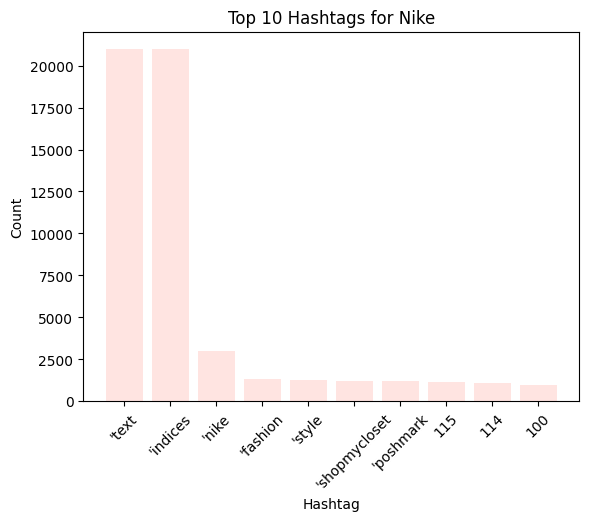

In [ ]:
# load dataset
df = pd.read_csv('nike_3k.csv')

# create list of all hashtags used
hashtags = []
stop_words = set(stopwords.words('english') + list(string.punctuation))
for i, row in df.iterrows():
    if pd.notnull(row['hashtags']):
        tokens = word_tokenize(row['hashtags'].lower())
        hashtags += [token for token in tokens if token not in stop_words]

# create pandas Series of hashtag counts
hashtags_series = pd.Series(hashtags).value_counts()

# create bar chart of top 10 hashtags
top_hashtags = hashtags_series.nlargest(10)
colors = [ 'orange']
plt.bar(top_hashtags.index, top_hashtags.values, color='mistyrose')
plt.xticks(rotation=45)
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.title('Top 10 Hashtags for Nike')
plt.show()

In [ ]:
# Load Nike tweets dataset
nike_df = pd.read_csv("nike_3k.csv")

# Preprocess text data
nike_df['text_processed'] = nike_df['text'].str.lower().replace(r'@[^\s]+|http\S+', '', regex=True).str.replace('[^\w\s]','')

# Vectorize text data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(nike_df['text_processed'])

# Perform NMF topic modeling
num_topics = 5
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(tfidf)

# Print top 10 words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
    print()

<ipython-input-24-7013211cf9d1>:5: FutureWarning:

The default value of regex will change from True to False in a future version.



Topic 1:
loving, shopmycloset, poshmark, items, share, good, im, style, check, fashion

Topic 2:
shoes, air_jordan_13, 7699, 13, jordan, sneakers, air, tagowear, tagolife, tagoteenet

Topic 3:
smith, stan, 6699, stan_smith_shoes, tagolife, tagoteenet, tagowear, buy, shoes, bishop

Topic 4:
mens, nike, black, white, size, ebay, shop, online, sale, shopping

Topic 5:
adidas, agadrianogoldschmied, check, items, shopmycloset, poshmark, good, im, fashion, loving



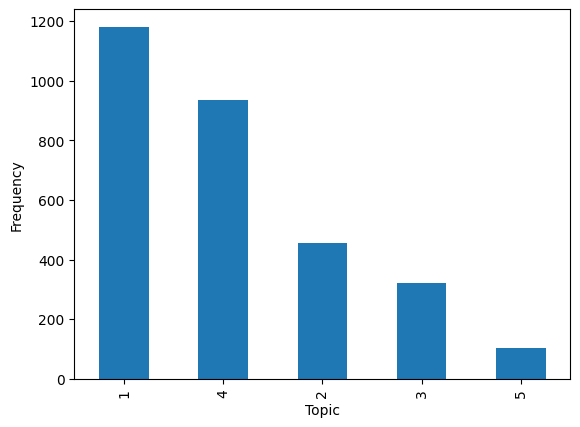

In [ ]:
# Get topic probabilities for each tweet
topic_probs = nmf.transform(tfidf)

# Get topic with highest probability for each tweet
top_topics = [prob.argmax()+1 for prob in topic_probs]

# Plot frequency of each topic
topic_counts = pd.Series(top_topics).value_counts()
topic_counts.plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Define function to preprocess text data
def preprocess_text(text):
    # Remove URLs and mentions
    text = gensim.utils.simple_preprocess(text, deacc=True, min_len=3)
    # Remove punctuation
    text = [word for word in text if word.isalnum()]
    return text

# Preprocess the tweet text column
nike_df['processed_text'] = nike_df['text'].apply(preprocess_text)

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(nike_df['processed_text'])
corpus = [dictionary.doc2bow(text) for text in nike_df['processed_text']]

# Set number of topics
num_topics = 5

# Perform LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

# Print the topics and their top words
for i, topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=True):
    print("Topic #" + str(i+1) + ": " + topic)

# Compute coherence score to evaluate model performance
coherence_score = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass').get_coherence()
print("Coherence Score: ", coherence_score)

Topic #1: 0.035*"nike" + 0.029*"https" + 0.016*"the" + 0.010*"amp" + 0.008*"retro" + 0.008*"soccer" + 0.008*"football" + 0.007*"kotd" + 0.007*"sports" + 0.007*"adidas"
Topic #2: 0.094*"https" + 0.057*"shoes" + 0.048*"now" + 0.047*"buy" + 0.047*"only" + 0.047*"tagoteenet" + 0.047*"tagowear" + 0.047*"tagolife" + 0.046*"nike" + 0.040*"bishop"
Topic #3: 0.051*"nike" + 0.042*"https" + 0.026*"the" + 0.013*"for" + 0.010*"you" + 0.008*"sneakerhead" + 0.007*"max" + 0.007*"airmax" + 0.007*"nba" + 0.007*"chicago"
Topic #4: 0.088*"https" + 0.045*"fashion" + 0.045*"the" + 0.045*"out" + 0.045*"check" + 0.045*"all" + 0.044*"style" + 0.044*"had" + 0.044*"nike" + 0.043*"share"
Topic #5: 0.074*"nike" + 0.057*"https" + 0.039*"jordan" + 0.030*"air" + 0.023*"and" + 0.010*"black" + 0.009*"low" + 0.009*"with" + 0.009*"white" + 0.008*"dunk"
Coherence Score:  -4.758680724834721


In [ ]:
pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 7.0 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

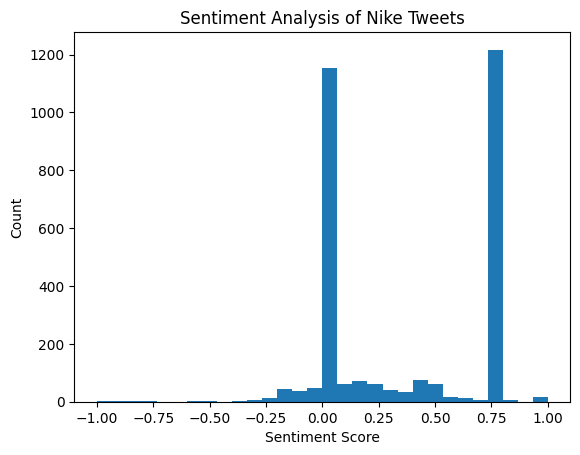

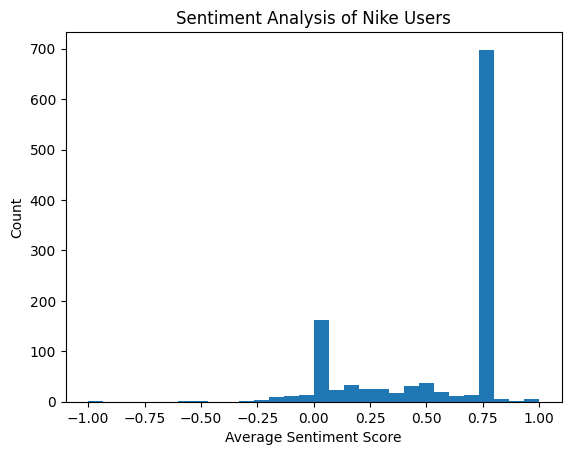

In [ ]:
# Load the Nike dataset
nike_df = pd.read_csv('nike_3k.csv')

# Calculate the sentiment polarity and subjectivity for each tweet
sentiment_scores = []
for text in nike_df['text']:
    blob = TextBlob(text)
    sentiment_scores.append(blob.sentiment.polarity)
nike_df['sentiment'] = sentiment_scores

# Plot the distribution of sentiment scores
plt.hist(nike_df['sentiment'], bins=30)
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Sentiment Analysis of Nike Tweets')
plt.show()

# Group the tweets by author_id and calculate the average sentiment for each user
user_sentiments = nike_df.groupby('author_id')['sentiment'].mean().reset_index()

# Plot the distribution of user sentiment scores
plt.hist(user_sentiments['sentiment'], bins=30)
plt.xlabel('Average Sentiment Score')
plt.ylabel('Count')
plt.title('Sentiment Analysis of Nike Users')
plt.show()

# Group the tweets by location and calculate the average sentiment for each location
location_sentiments = nike_df.groupby('location')['sentiment'].mean().reset_index()

Average sentiment score for Nike tweets: 0.40


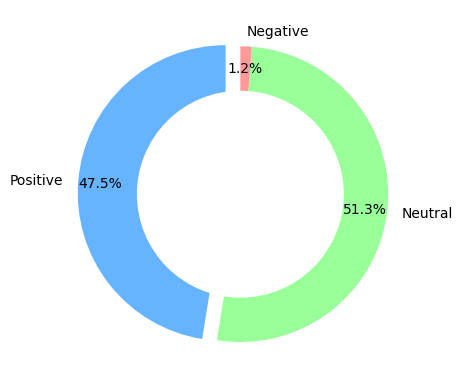

In [ ]:
# Instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to compute sentiment score for each tweet
def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# Compute sentiment scores for all tweets
nike_df['sentiment_score'] = nike_df['text'].apply(get_sentiment_score)

# Compute the average sentiment score for Nike tweets
avg_sentiment = nike_df['sentiment_score'].mean()
print(f'Average sentiment score for Nike tweets: {avg_sentiment:.2f}')

# Compute the percentage of positive, neutral, and negative tweets
positive_tweets = nike_df[nike_df['sentiment_score'] > 0.5]
neutral_tweets = nike_df[(nike_df['sentiment_score'] >= -0.5) & (nike_df['sentiment_score'] <= 0.5)]
negative_tweets = nike_df[nike_df['sentiment_score'] < -0.5]

positive_pct = len(positive_tweets) / len(nike_df) * 100
neutral_pct = len(neutral_tweets) / len(nike_df) * 100
negative_pct = len(negative_tweets) / len(nike_df) * 100

# Plot a pie chart of sentiment percentages
labels = ['Positive', 'Neutral', 'Negative']
sizes = [positive_pct, neutral_pct, negative_pct]
colors = ['#66b3ff','#99ff99','#ff9999']
explode = (0.1, 0, 0) 

plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

In [ ]:
emotions = {
    "anger": "anger",
    "disgust": "disgust",
    "fear": "fear",
    "joy": "joy",
    "sadness": "sadness",
    "surprise": "surprise",
    "trust": "trust"
}

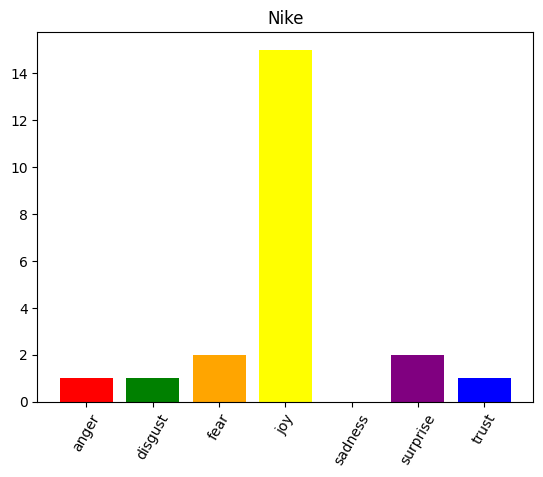

In [ ]:
cols = ["red", "green", "orange", "yellow", "skyblue", "purple", "blue", "black", "grey"]

nike_df = pd.read_csv("nike_3k.csv")

def get_nrc_sentiment(df):
    sentiments = {"anger": [], "disgust": [], "fear": [], "joy": [], "sadness": [], "surprise": [], "trust": []}
    for index, row in df.iterrows():
        text = row["text"]
        for word in emotions.keys():
            if word in text.lower():
                sentiments[emotions[word]].append(row)
                break
    max_len = max([len(sentiments[key]) for key in sentiments.keys()])
    for key in sentiments.keys():
        if len(sentiments[key]) < max_len:
            sentiments[key] += [None] * (max_len - len(sentiments[key]))
    return pd.DataFrame(sentiments)

nike_sentimentsdf = get_nrc_sentiment(nike_df)

plt.bar(np.arange(len(nike_sentimentsdf.columns)), nike_sentimentsdf.count().values, color=cols[:len(nike_sentimentsdf.columns)], width=0.8)
plt.title("Nike")
plt.xticks(np.arange(len(nike_sentimentsdf.columns)), nike_sentimentsdf.columns, rotation=60)
plt.show()

In [40]:
# Load the dataset
nike_df = pd.read_csv('nike_3k.csv')

# Get the unique locations mentioned in the dataset
locations = nike_df['location'].unique()

# Geocode the locations to get latitude and longitude
geolocator = Nominatim(user_agent='myapplication')
latitudes = []
longitudes = []
for location in locations:
    try:
        loc = geolocator.geocode(location)
        latitudes.append(loc.latitude)
        longitudes.append(loc.longitude)
    except:
        latitudes.append(None)
        longitudes.append(None)

# Create a map and add markers for the locations
nike_map = folium.Map(location=[37.0902, -95.7129], zoom_start=3)
for i in range(len(locations)):
    if latitudes[i] and longitudes[i]:
        folium.Marker([latitudes[i], longitudes[i]]).add_to(nike_map)

# Display the map
nike_map

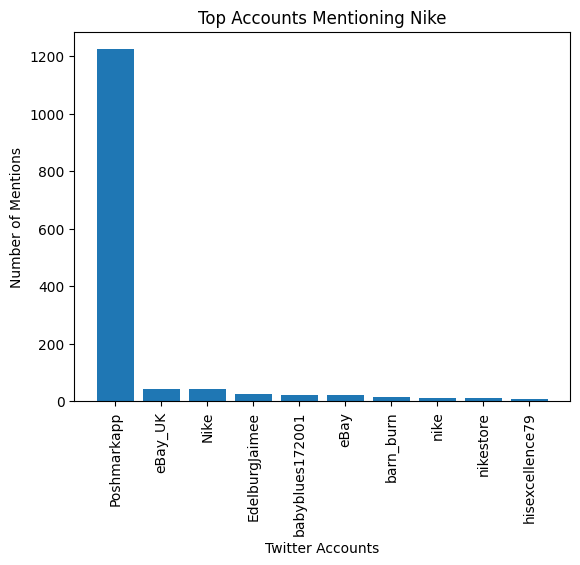

In [2]:
# Read in the Nike dataset
nike_3k = pd.read_csv("nike_3k.csv")

# Create a list of all the unique accounts that mention Nike in their tweets
accounts = nike_3k[nike_3k["text"].str.contains("@")]["text"].str.extractall(r"@([^\s:]+)").reset_index()[0].unique()

# Count how many times each account mentions Nike in their tweets
account_counts = nike_3k[nike_3k["text"].str.contains("@")]["text"].str.extractall(r"@([^\s:]+)").reset_index().groupby(0).count()

# Sort the accounts by their count and take the top 10
top_accounts = account_counts.sort_values(by="level_0", ascending=False).head(10)

# Plot a bar chart of the top 10 accounts that mention Nike
plt.bar(top_accounts.index, top_accounts["level_0"])
plt.xticks(rotation=90)
plt.xlabel("Twitter Accounts")
plt.ylabel("Number of Mentions")
plt.title("Top Accounts Mentioning Nike")
plt.show()

In [3]:
# Load the dataset
dataset = pd.read_csv('nike_3k.csv')

# Filter for posts with positive sentiment towards Nike
nike_posts = dataset.loc[dataset['text'].str.contains('Nike', case=False)]

# Calculate the engagement rate for each author
nike_posts['engagement_rate'] = (nike_posts['favorite_count'] + nike_posts['retweet_count']) / nike_posts['followers_count']

# Filter authors based on the given criteria
nike_posts = nike_posts.loc[(nike_posts['verified'] == True) & (nike_posts['followers_count'] >= 10000) & (nike_posts['favourites_count'] >= 1000)]

# Find the author with the highest engagement rate
suitable_influencer = nike_posts.loc[nike_posts['engagement_rate'].idxmax()]

# Check the relevance of the author to the Nike brand
if 'Nike' in suitable_influencer['text'] or 'nike' in suitable_influencer['text']:
    print(f"The most suitable micro-influencer for Nike is {suitable_influencer['author_id']} ")
    print(f"\nThe tweet is: {suitable_influencer['text']}")
    print(f"\nFollowers of the micro-influencer: {suitable_influencer['followers_count']}")

The most suitable micro-influencer for Nike is 36359553.0 

The tweet is: ARTEMIS is back! 🤗

It doesn’t even have to “kick” the ball and it’s already like bowling! ⚽️🥅

#ARTEMIS #humanoid #robot
#Nike #JustDoIt 
@RoMeLaUCLA 
@UCLAengineering 
@UCLA 
@UCLAAthletics https://t.co/nQREH7L07c

Followers of the micro-influencer: 12107



Total number of tweets by the author: 1
Average number of retweets per tweet: 5.00
Average number of favorites per tweet: 41.00
Languages used by the author: ['en']
Locations of the author: ['Los Angeles, CA']


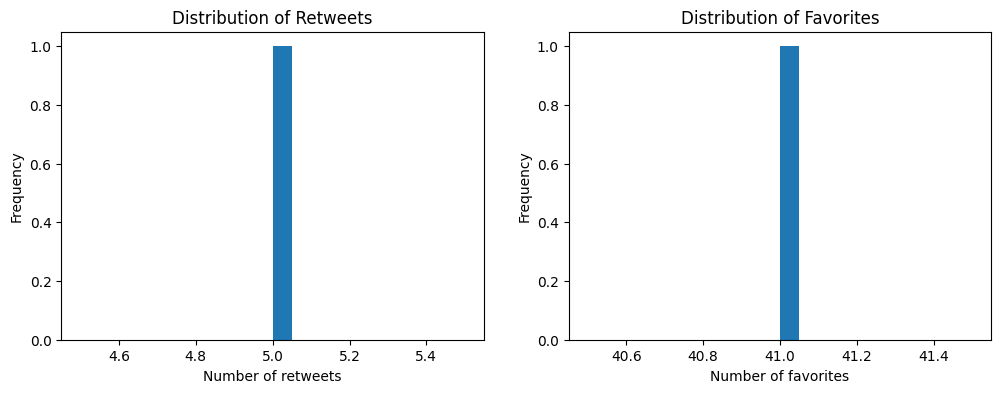

In [4]:
# Descriptive analysis of the author's profile
author_profile = dataset.loc[dataset['author_id'] == suitable_influencer['author_id']]
print(f"\nTotal number of tweets by the author: {author_profile.shape[0]}")
print(f"Average number of retweets per tweet: {author_profile['retweet_count'].mean():.2f}")
print(f"Average number of favorites per tweet: {author_profile['favorite_count'].mean():.2f}")
print(f"Languages used by the author: {author_profile['lang'].unique()}")
print(f"Locations of the author: {author_profile['location'].unique()}")

# Plot the distribution of retweets and favorites
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(author_profile['retweet_count'], bins=20)
ax[0].set_xlabel('Number of retweets')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Retweets')
ax[1].hist(author_profile['favorite_count'], bins=20)
ax[1].set_xlabel('Number of favorites')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Favorites')
plt.show()


Total number of tweets by the author: 1
Average number of retweets per tweet: 5.00
Average number of favorites per tweet: 41.00
Languages used by the author: ['en']
Locations of the author: ['Los Angeles, CA']


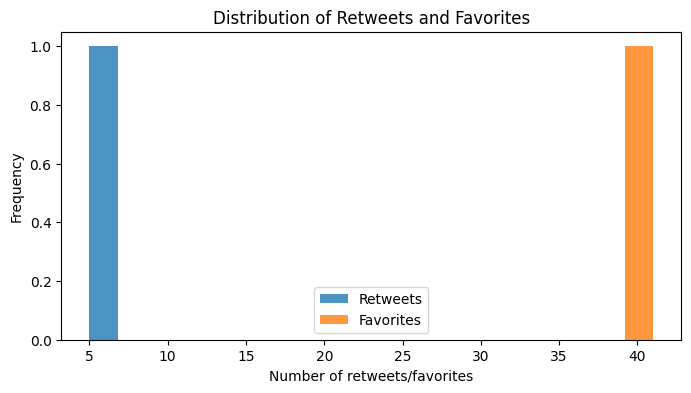

In [10]:
# Descriptive analysis of the author's profile
author_profile = dataset.loc[dataset['author_id'] == suitable_influencer['author_id']]
print(f"\nTotal number of tweets by the author: {author_profile.shape[0]}")
print(f"Average number of retweets per tweet: {author_profile['retweet_count'].mean():.2f}")
print(f"Average number of favorites per tweet: {author_profile['favorite_count'].mean():.2f}")
print(f"Languages used by the author: {author_profile['lang'].unique()}")
print(f"Locations of the author: {author_profile['location'].unique()}")
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist([author_profile['retweet_count'], author_profile['favorite_count']], bins=20, label=['Retweets', 'Favorites'], alpha=0.8, stacked=True)
ax.set_xlabel('Number of retweets/favorites')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Retweets and Favorites')
ax.legend()
plt.show()